# CELEB-A

In [1]:
import warnings
warnings.filterwarnings('ignore')


%pylab inline

import tensorflow.compat.v1 as tf
import tensorflow_datasets as tfds
from tqdm import tqdm_notebook as tqdm
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import numpy as np
from ops import *
from utils import *
import os
import time
from glob import glob
#from scipy.misc import imsave as ims
from random import randint
from data_providers import *
import scipy as sp
import pickle
from tensorflow.keras import datasets
import tensorflow.data as td

config = tf.ConfigProto(
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=.3),
    device_count = {'GPU': 1}
)

#print(tf.__version__)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import tensorflow.keras.preprocessing.image  as image

Populating the interactive namespace from numpy and matplotlib
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
params = {
    'batch_size':64,
    'image_dim':32*32*3,
    'imageshape': [64,32,32,3],
    'c':3,
    'h':32,
    'w':32,
    'epochs' :20,
    'noise_dim':128
}

In [3]:
'''Notice that unlike usual GAN, this is not a binary classifier. The output is a vector of dim 3.'''
def discriminator(z, z_dim=params['noise_dim'], reuse=False, training=True):
    
    with tf.variable_scope("disc") as scope:
        if reuse:
                scope.reuse_variables()
      
        h0 = z
        h1 = lrelu(slim.fully_connected(h0, int(z_dim/2))) 
        h1 = slim.dropout(h1, keep_prob=0.5, is_training=training)
        h2 = lrelu(slim.fully_connected(h1, int(z_dim/4)))
        h2 = slim.dropout(h2, keep_prob=0.5, is_training=training)
        h3 = slim.fully_connected(h2, 3)

        return h3
    
    
def encoder(image, z_dim=params['noise_dim'], batchsize=params['batch_size'], h=params['h'], w=params['w'], c=params['c'], df_dim=params['h']):
    with tf.variable_scope("encoder") as scope:
      
        h0 = image
        h0 = lrelu(conv2d(h0, 3, df_dim, name='d_h0_conv')) #16x16x32
        h1 = lrelu(tf.contrib.layers.batch_norm(conv2d(h0, df_dim, df_dim*2, name='d_h1_conv'))) #8x8x64
        h2 = lrelu(tf.contrib.layers.batch_norm(conv2d(h1, df_dim*2, df_dim*2*2, name='d_h2_conv'))) #4x4x128
        h3 = tf.reshape(h2, [batchsize, -1])
        mu = dense(h3, 4*4*df_dim*4, z_dim, scope='d_h4_lin_mu') #2048

        return mu
    

        
def generator(z,z_dim=params['noise_dim'],batchsize=params['batch_size'],h=params['h'],w=params['w'],c=params['c'],gf_dim=params['h'],reuse=False):
    with tf.variable_scope("gen") as scope:
        if reuse:
                scope.reuse_variables()
        z2 = dense(z, z_dim, 4*4*gf_dim*4, scope='g_h0_lin')
        h0 = tf.nn.relu(tf.contrib.layers.batch_norm(tf.reshape(z2, [-1, 4, 4, gf_dim*4]))) # 4x4x128
        h1 = tf.nn.relu(tf.contrib.layers.batch_norm(conv_transpose(h0, [batchsize, 8, 8, gf_dim*2], "g_h1"))) #8x8x64
        h2 = tf.nn.relu(tf.contrib.layers.batch_norm(conv_transpose(h1, [batchsize, 16, 16, gf_dim*1], "g_h2"))) #16x16x32
        h3 = tf.nn.sigmoid(conv_transpose(h2, [batchsize, h, w, c], "g_h4"))

        return h3  
    
    

        

In [4]:
from PIL import Image
from tqdm import tqdm

PIC_DIR =  "data/img_align_celeba/"
IMAGES_COUNT = 5000

ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

WIDTH = 128
HEIGHT = 128

crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR + pic_file).crop(crop_rect)
    pic = pic.resize((32, 32))
    pic.thumbnail((32, 32), Image.ANTIALIAS)
    
    images.append(np.uint8(pic))

images = float32(np.array(images) / 255)

images.shape
type(images)

100%|██████████| 5000/5000 [00:11<00:00, 425.68it/s]


numpy.ndarray

In [5]:
print(images.shape)

(5000, 32, 32, 3)


In [6]:

x = images
print(x.dtype)
train_images, validation_images, test_images = x[:5000,:, :, :], x[5000:7000,:, :, :], x[7000:9000,:, :, :]
train_images.shape

float32


(5000, 32, 32, 3)

In [7]:
import tensorflow_probability as tfp
import math
tf.reset_default_graph()

tfd = tfp.distributions
class_num = 10
c_const = 9.9
sigma_const = 0.005
gm_mus = np.eye(class_num, params['noise_dim'])* c_const

gm_mus = gm_mus.tolist()
## Let mean of each Gaussian be an indicator, aka one hot code
gm_sigma = sigma_const
gm_cov_diag = np.eye(class_num, params['noise_dim']) * gm_sigma * gm_sigma
gm_cov_diag = gm_cov_diag.tolist()



mix = 1.0/class_num ### mixing coef
gm_probs = np.repeat(mix, class_num) ## The vector of mixing_probs
        
gm_distr = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=gm_probs),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=gm_mus, scale_diag=gm_cov_diag)
)


# DataLoader and iterator
batch = td.Dataset.from_tensor_slices(train_images).shuffle(len(train_images), reshuffle_each_iteration=True).repeat().batch(params['batch_size'], drop_remainder=True).prefetch(10)
print('Dataset Object:', batch)
iterator = batch.make_initializable_iterator()
batch_images = iterator.get_next()
print('Iterator:' ,batch_images)

Dataset Object: <DatasetV1Adapter shapes: (64, 32, 32, 3), types: tf.float32>
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.
Iterator: Tensor("IteratorGetNext:0", shape=(64, 32, 32, 3), dtype=float32)


In [8]:
batch_images

<tf.Tensor 'IteratorGetNext:0' shape=(64, 32, 32, 3) dtype=float32>

In [9]:



# Placeholders for input 
gen_input = tf.placeholder(tf.float32, shape=[None, params['noise_dim']], name='input_noise')
m_input = tf.placeholder(tf.float32, shape=[None, params['noise_dim']], name='m_input')
n_input = tf.placeholder(tf.float32, shape=[None, params['noise_dim']], name='n_input')


# Build VAE Network
z = encoder(batch_images)
eps = gm_distr.sample(params['batch_size'])
gen_sample = generator(z)
# Random Sampler
gen_rv = generator(gen_input,reuse=True)

# Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(eps)
disc_fake = discriminator(z,reuse=True)
disc_m = discriminator(eps+m_input,reuse=True)
disc_m_gen = discriminator(z+n_input,reuse=True)

# Build Loss



a = np.tile([1.,0.,0.],params['batch_size'])
b = np.tile([0.,1.,0.],params['batch_size'])
c = np.tile([0.,0.,1.],params['batch_size'])
label_a = tf.reshape(a,[params['batch_size'],3])
label_b = tf.reshape(b,[params['batch_size'],3])
label_c = tf.reshape(c,[params['batch_size'],3])

disc_loss_1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=disc_real, labels=label_a))
disc_loss_2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=disc_fake, labels=label_b))
disc_loss_3 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=disc_m, labels=label_c))
disc_loss_4 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=disc_m_gen, labels=label_c))
dloss = disc_loss_1 + disc_loss_2 + disc_loss_3 + disc_loss_4

r_p_m = (tf.nn.softmax(disc_m_gen)[:,0])/(tf.nn.softmax(disc_m_gen)[:,2])
r_q_m = (tf.nn.softmax(disc_m_gen)[:,1])/(tf.nn.softmax(disc_m_gen)[:,2])

sbd = tf.square(r_p_m - 1) - tf.square(r_q_m - 1) - 2*(r_q_m-1)*(r_p_m-r_q_m)
sbd_loss = tf.reduce_mean(sbd)
#kld = -0.5 * tf.reduce_sum(1 + log_sigma_sq - tf.square(mu) - tf.exp(log_sigma_sq), 1)
BCE = -tf.reduce_sum(tf.reshape(batch_images, [params['batch_size'], -1]) * tf.log(1e-10 + tf.reshape(gen_sample, [params['batch_size'], -1]))
                           + (1-tf.reshape(batch_images, [params['batch_size'], -1])) * tf.log(1e-10 + 1 - tf.reshape(gen_sample, [params['batch_size'], -1])),1)
vaeloss = tf.reduce_mean(sbd + BCE)
      
#Build Optimizers
t_vars = tf.trainable_variables()
e_vars = [var for var in t_vars if 'encoder' in var.name]
g_vars = [var for var in t_vars if 'gen' in var.name]
d_vars = [var for var in t_vars if 'disc' in var.name]

learningrate_gen = 1e-4
learningrate = 1e-4
beta1 = 0.5
g_optim = tf.train.AdamOptimizer(learningrate_gen, beta1=beta1).minimize(vaeloss, var_list=g_vars+e_vars)
d_optim = tf.train.AdamOptimizer(learningrate,     beta1=beta1).minimize(dloss, var_list=d_vars)

#Initialize
start_time = time.time()
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
sess.run(iterator.initializer)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [10]:
#print(type(batch_images['image']))
#batch_images.keys()

100%|██████████| 78/78 [00:22<00:00,  3.52it/s]


Epoch: [ 0] [  77/  78] time: 24.7527, dloss: 4.1190, gloss: 1844.4287,SBD: 2.7427


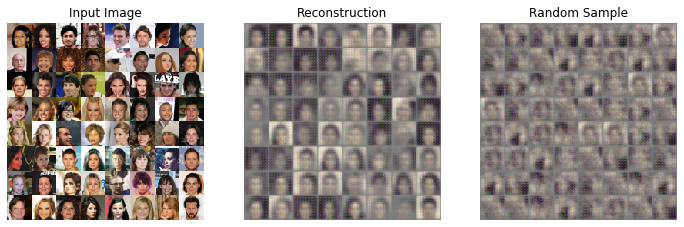

100%|██████████| 78/78 [00:17<00:00,  4.40it/s]


Epoch: [ 1] [  77/  78] time: 43.1949, dloss: 3.7040, gloss: 1759.4357,SBD: 0.2589


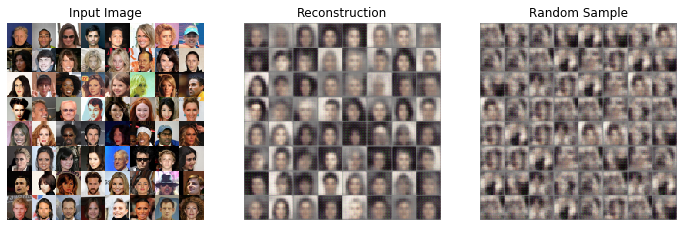

100%|██████████| 78/78 [00:17<00:00,  4.41it/s]


Epoch: [ 2] [  77/  78] time: 61.2195, dloss: 3.0829, gloss: 1674.9524,SBD: 0.1730


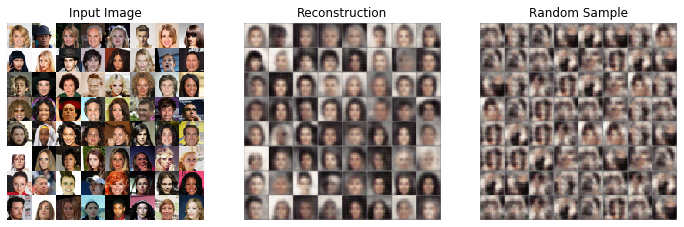

100%|██████████| 78/78 [00:18<00:00,  4.32it/s]


Epoch: [ 3] [  77/  78] time: 79.5611, dloss: 2.4024, gloss: 1702.8492,SBD: 0.3263


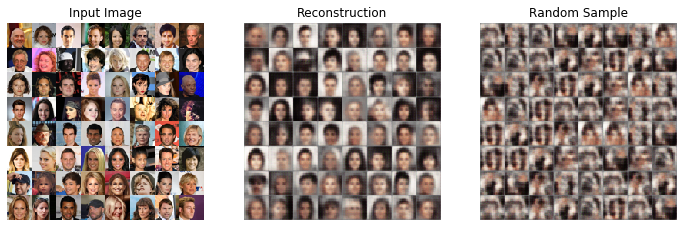

100%|██████████| 78/78 [00:20<00:00,  3.82it/s]


Epoch: [ 4] [  77/  78] time: 100.3435, dloss: 1.9962, gloss: 1669.5364,SBD: 0.1740


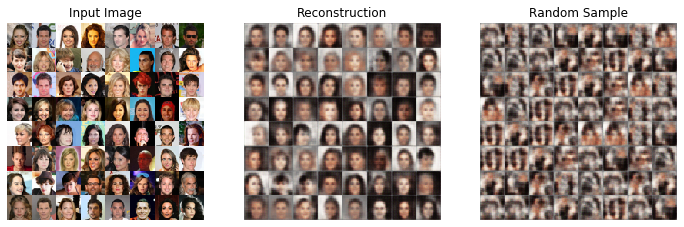

100%|██████████| 78/78 [00:17<00:00,  4.48it/s]


Epoch: [ 5] [  77/  78] time: 118.0532, dloss: 2.0221, gloss: 1646.6812,SBD: 2.4034


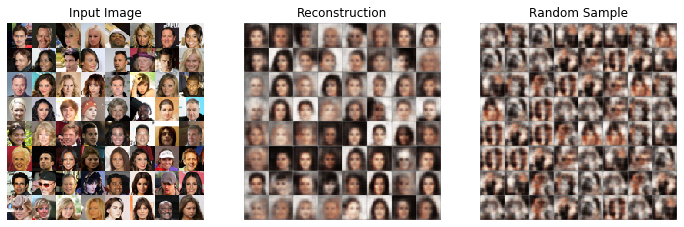

100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


Epoch: [ 6] [  77/  78] time: 137.2584, dloss: 1.3506, gloss: 1702.1332,SBD: 0.3832


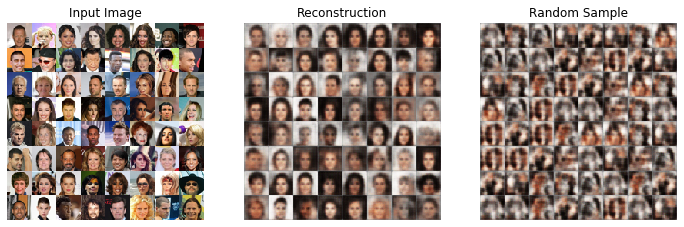

100%|██████████| 78/78 [00:18<00:00,  4.27it/s]


Epoch: [ 7] [  77/  78] time: 155.8279, dloss: 0.9690, gloss: 3974.4321,SBD: 2301.1973


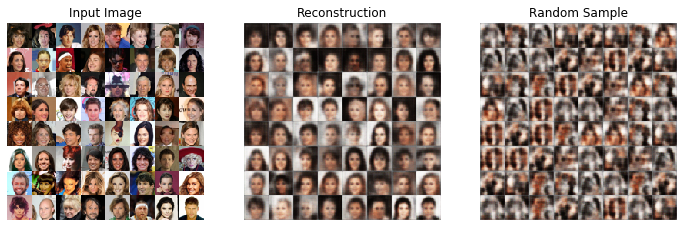

100%|██████████| 78/78 [00:17<00:00,  4.39it/s]


Epoch: [ 8] [  77/  78] time: 173.9185, dloss: 0.6972, gloss: 1608.2103,SBD: 0.5668


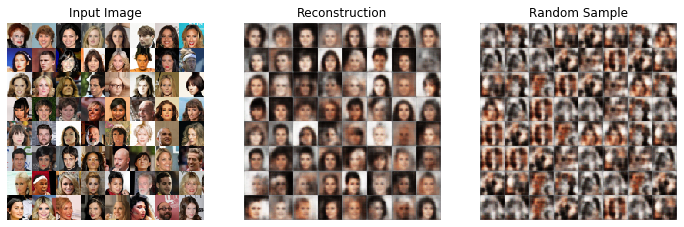

100%|██████████| 78/78 [00:18<00:00,  4.32it/s]


Epoch: [ 9] [  77/  78] time: 192.2744, dloss: 1.3538, gloss: 1758.7523,SBD: 0.1151


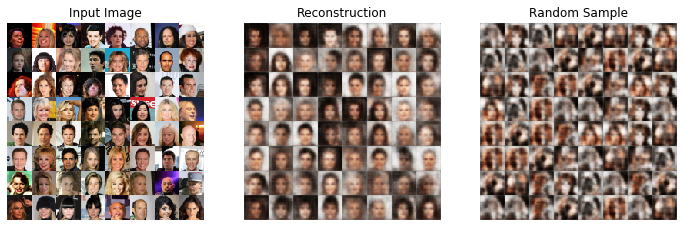

100%|██████████| 78/78 [00:16<00:00,  4.60it/s]


Epoch: [10] [  77/  78] time: 209.5774, dloss: 0.8614, gloss: 1713.0391,SBD: 27.4463


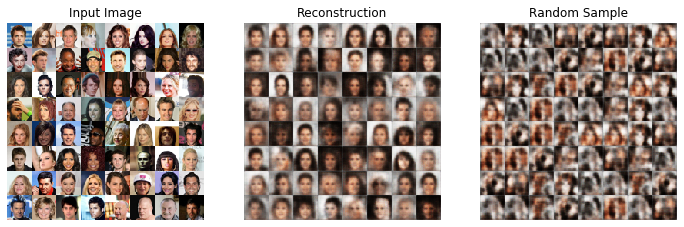

100%|██████████| 78/78 [00:16<00:00,  4.72it/s]


Epoch: [11] [  77/  78] time: 226.3799, dloss: 0.7885, gloss: 254885.0469,SBD: 253215.3594


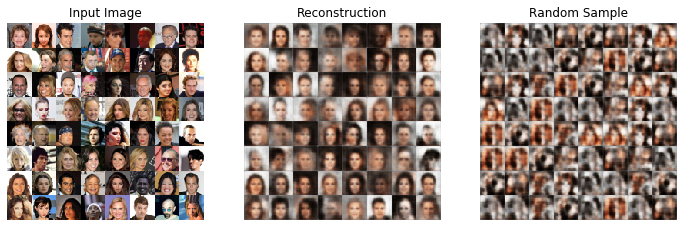

100%|██████████| 78/78 [00:17<00:00,  4.38it/s]


Epoch: [12] [  77/  78] time: 244.4996, dloss: 0.3895, gloss: 1668.9476,SBD: 0.0989


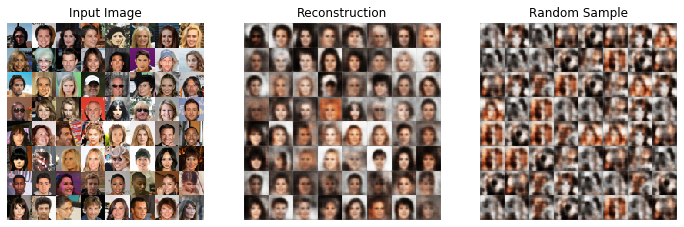

100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


Epoch: [13] [  77/  78] time: 263.5130, dloss: 0.2952, gloss: 1647.3989,SBD: 0.0670


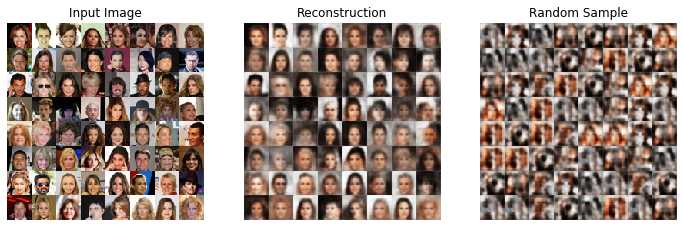

100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Epoch: [14] [  77/  78] time: 283.1690, dloss: 4.4341, gloss: 1989.8228,SBD: 61.0638


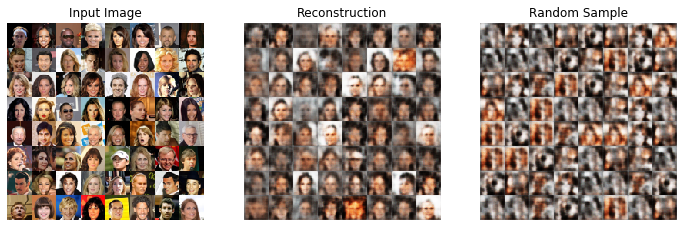

100%|██████████| 78/78 [00:17<00:00,  4.38it/s]


Epoch: [15] [  77/  78] time: 301.2455, dloss: 0.5102, gloss: 1726.4006,SBD: 25.2978


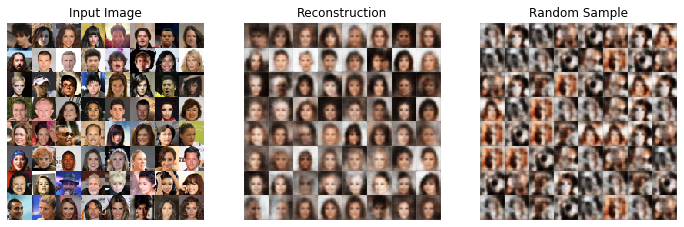

100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


Epoch: [16] [  77/  78] time: 320.3126, dloss: 0.3453, gloss: 1680.0186,SBD: 0.3858


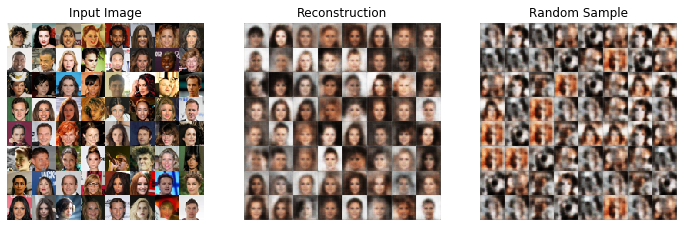

100%|██████████| 78/78 [00:17<00:00,  4.53it/s]


Epoch: [17] [  77/  78] time: 337.8479, dloss: 0.1782, gloss: 1637.1499,SBD: 0.0591


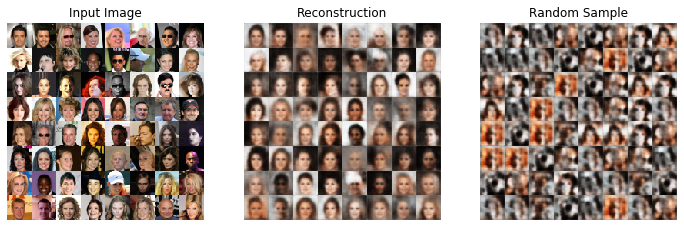

100%|██████████| 78/78 [00:17<00:00,  4.44it/s]


Epoch: [18] [  77/  78] time: 355.7166, dloss: 0.2382, gloss: 1666.6047,SBD: 4.9099


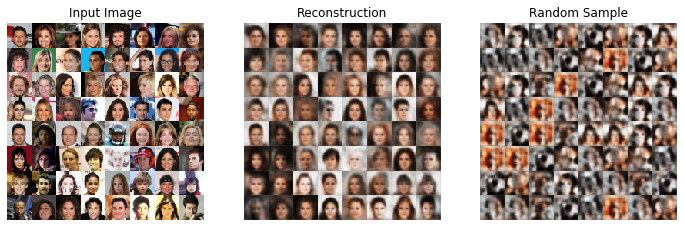

100%|██████████| 78/78 [00:17<00:00,  4.50it/s]


Epoch: [19] [  77/  78] time: 373.3216, dloss: 0.4296, gloss: 1695.6625,SBD: 0.8552


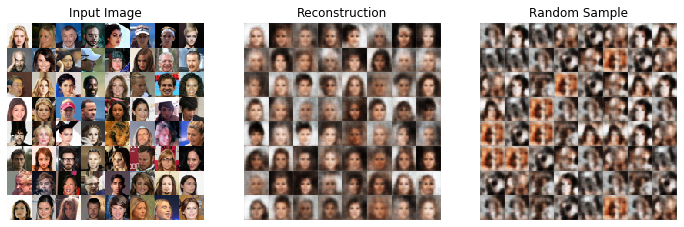

100%|██████████| 20/20 [06:11<00:00, 18.55s/it]


In [11]:
# '------Training VAE and SBD Networks--------------------'
with sess.as_default():
    batch_z = gm_distr.sample(params['batch_size']).eval()
num_batches = int(len(train_images)/params['batch_size'])
dl,gl,sl=0,0,0
for epoch in tqdm(xrange(params['epochs'])):
    for idx in tqdm(range(num_batches)):
        
     
        sigma_n = 3.0 * c_const * 12.0 * sigma_const
        n_cov = np.eye(params['noise_dim'], params['noise_dim'])*sigma_n *sigma_n
        n_mean = np.repeat(0.0, params['noise_dim'])
        m  = np.random.multivariate_normal(n_mean, n_cov, params['batch_size'])#Updated
        n_cov = np.eye(params['noise_dim'], params['noise_dim'])*sigma_n *sigma_n
        n_mean = np.repeat(0.0, params['noise_dim'])
        n_ = np.random.multivariate_normal(n_mean, n_cov, params['batch_size'])#Updated

        # Train
        feed_dict = {m_input: m, n_input: n_}
        for _ in range(4):
            sess.run([d_optim],feed_dict=feed_dict)
        _, _, gl, dl, sl = sess.run([d_optim, g_optim, vaeloss, dloss, sbd_loss],
                                feed_dict=feed_dict)
        
        
#     '---------Printing intermediate results-------------'      
    if epoch % 1 == 0:
        
        print("Epoch: [%2d] [%4d/%4d] time: %4.4f, dloss: %4.4f, gloss: %4.4f,SBD: %4.4f" % (epoch, idx, num_batches, time.time() - start_time, dl,gl,sl))
        
        images = sess.run([batch_images,gen_sample,gen_rv],feed_dict = {gen_input: batch_z})
        fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(12,12))
        t = ['Input Image', 'Reconstruction', 'Random Sample']
        for i,image in enumerate(images):
            sdata = np.expand_dims(image,0)
            img = merge(sdata[0],[8,8])
            ax[i].imshow(img)
            ax[i].set_title(t[i])
            ax[i].axis('off')
        plt.show()
    




In [15]:
'''Generate random samples and save to compute FID later.'''
batchsize = params['batch_size']
z_dim=params['noise_dim']
with sess.as_default():
    batch_z_eval = gm_distr.sample(params['batch_size']).eval()

gen_images = np.vstack([sess.run(gen_sample,feed_dict={ \
            gen_input: batch_z_eval.astype(np.float32) }) for _ in range(250)])

print(gen_images.shape)
np.save("celeba_breg_vae3_structuredPrior",gen_images)

(16000, 32, 32, 3)
